In [1]:
!nvidia-smi

Tue Aug 20 12:55:16 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#@title Import module
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/Src")
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [3]:
#@title ShapesConfig { vertical-output: true }
#@Config
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 1600

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 150

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 35
configGPU = tf.ConfigProto(allow_soft_placement=True)
configGPU.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=configGPU))
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1600
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1600 1600    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
#@title ShapeDataset { vertical-output: true }
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_csv(self, csv_path, debug=False):
        # Add classes
        self.add_class("SDD", 1, "dot")
        self.add_class("SDD", 2, "line")
        self.add_class("SDD", 3, "surfaceScratch")
        self.add_class("SDD", 4, "deepScratch")
        self.classNames = ["dot", "line", "surfaceScratch", "deepScratch"]
        f = open(csv_path,'rt')
        data = csv.reader(f)
        imgList = []
        encodePixelsList = []
        for row in data:
            imgList.append(row[0])
            encodePixelsList.append(row[1])
        f.close()
        print(len(imgList))
        train_path = "/content/drive/My Drive/Colab Notebooks/Src/train_images/"
        no = 0
        img_id = 0
        for i in range(1, len(imgList)):
            if encodePixelsList[i]!="":
                className = self.classNames[int(imgList[i][-1])-1]
                img_path = train_path + imgList[i][:-2]
                #print(img_path + " ------ " + className)
                #img = cv2.imread(img_path)
                #h, w = img.shape[:2]
                h = 256
                w = 1600
                self.add_image("SDD", 
                               image_id=img_id, 
                               path=img_path, 
                               width=w, 
                               height=h, 
                               encodePixels=encodePixelsList[i], 
                               class_id=[className])
                img_id = img_id + 1
                #print(no)
                no = no + 1
                #if no==15:
                #    break
                #else:
                #    no = no + 1
    
    def create_mask(self, h, w, encodePixels):
        encodePixels = encodePixels.split(" ")
        mask = []
        i = 0
        while (i < len(encodePixels)):
            t = [encodePixels[i], encodePixels[i+1]]
            mask.append(t)
            i = i+2
        #grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #npImg = np.asarray(grayImg)
        maskImg = np.zeros([h,w], dtype=np.uint8) # np.reshape(npImg, h*w, order='F')
        maskImg = np.reshape(maskImg, h*w, order='F')
        for i in range(len(mask)):
            for j in range(int(mask[i][1])):
                id = int(mask[i][0])+j
                try:
                    maskImg[id] = 1
                except:
                    print(mask[i][0] + "----" + mask[i][1])
                    print(id)
        maskImg = np.reshape(maskImg, (h,w), order="F")
        maskImg=np.expand_dims(maskImg, axis=2)
        return maskImg.astype(np.bool)
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        #mask = np.zeros([info["height"], info["width"], len(info['class_id'])],
         #               dtype=np.uint8)
        encodePixels = info["encodePixels"]
        mask = self.create_mask(info["height"], info["width"], encodePixels)
        class_ids = np.zeros([len(info['class_id'])], dtype=np.int32)
        for i, p in enumerate(info['class_id']):
            if self.classNames.index(p)!=-1:
                class_ids[i] = self.classNames.index(p)
        class_ids = class_ids.astype(int)
        # Map class names to class IDs.
        return mask, class_ids.astype(np.int32)
    
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        image = cv2.imread(info["path"])
        
        return image

In [5]:
#@title Load data { vertical-output: true }
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_csv("/content/drive/My Drive/Colab Notebooks/Src/train.csv")
dataset_train.prepare()

dataset_val = ShapesDataset()
dataset_val.load_csv("/content/drive/My Drive/Colab Notebooks/Src/val.csv")
dataset_val.prepare()

4972
1058


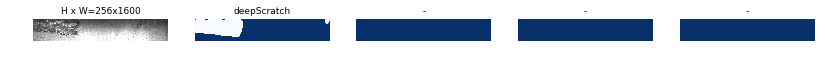

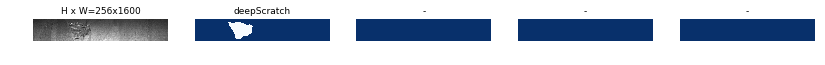

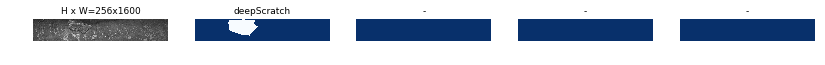

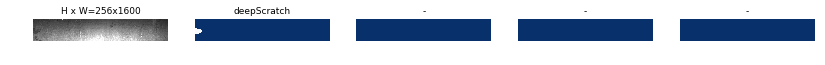

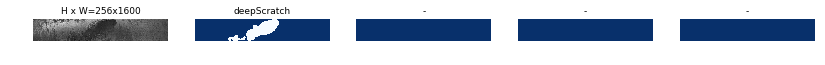

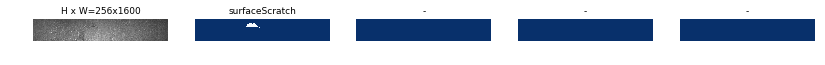

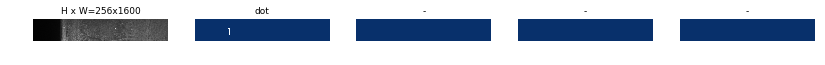

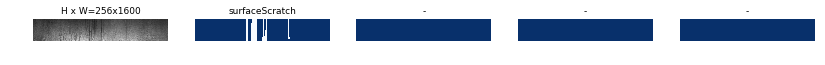

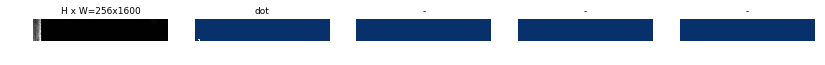

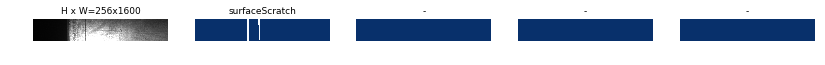

In [6]:
#@title Debug train/val data
n = 0
for i in range(5):
    mask, class_ids = dataset_train.load_mask(i)
    
    img = dataset_train.load_image(i)
    visualize.display_top_masks(img, mask, class_ids+1, dataset_train.class_names)
    
n = 0
for i in range(5):
    mask, class_ids = dataset_val.load_mask(i)
    
    img = dataset_val.load_image(i)
    visualize.display_top_masks(img, mask, class_ids+1, dataset_val.class_names)

In [9]:
!nvidia-smi

Tue Aug 20 12:56:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    72W / 149W |    645MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
#@title Create model { vertical-output: true }
#Create model
MODEL_DIR = "/content/drive/My Drive/Colab Notebooks/Src/logs"
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

model.load_weights("/content/drive/My Drive/Colab Notebooks/Src/logs/mask_rcnn_shapes_0031.h5", by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

W0820 12:55:49.169146 139832515577728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 12:55:49.189717 139832515577728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 12:55:49.235570 139832515577728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 12:55:49.284476 139832515577728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0820 12:55:49.289625 139832515

In [0]:
#@title Train
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=3000, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/Src/logs/shapes20190820T1256/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b     

W0820 12:56:10.299863 139832515577728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/3000
150/150 [==============================] - 685s 5s/step - loss: 3.5891 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 1.9174 - mrcnn_class_loss: 0.4178 - mrcnn_bbox_loss: 0.7984 - mrcnn_mask_loss: 0.4523 - val_loss: 3.5604 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 2.6916 - val_mrcnn_class_loss: 0.1586 - val_mrcnn_bbox_loss: 0.4627 - val_mrcnn_mask_loss: 0.2403
Epoch 2/3000
150/150 [==============================] - 607s 4s/step - loss: 3.4975 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 2.3444 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.5591 - mrcnn_mask_loss: 0.3784 - val_loss: 3.4942 - val_rpn_class_loss: 9.6685e-04 - val_rpn_bbox_loss: 2.7686 - val_mrcnn_class_loss: 0.0449 - val_mrcnn_bbox_loss: 0.3459 - val_mrcnn_mask_loss: 0.3339
Epoch 3/3000
150/150 [==============================] - 600s 4s/step - loss: 3.7684 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 2.6585 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.4026 - val_loss: 3.5632 - val_r

In [0]:
import os
import shutil
os.listdir()

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
!cat /proc/meminfo